In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd "/content/drive/My Drive/CMSC6950/PROJECT"
# !ls

In [3]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import skew
from statistics import median
import matplotlib.pyplot as plt
from collections import defaultdict


# Exploring the Data

In [4]:
country_counts = {}

def process_chunk(chunk):
    """Process chunks of data at a time from the csv dataset,
        the function populates the global dict 'country_counts' with each countries and the number
        of publied papers
    Args:
        chunk (<class 'pandas.core.frame.DataFrame'>): pandas data frame chunk
    """
    global country_counts
    for countries_list_str in chunk['countries']:
        # Convert the string representation of the list into an actual list
        try:
            countries_list = ast.literal_eval(countries_list_str)
        except ValueError:
            continue

        # Update the country counts/skipping 'nf'(not found)
        for country in countries_list:
            if country == 'nf':
                continue

            if country in country_counts:
                country_counts[country] += 1
            else:
                country_counts[country] = 1

chunk_size = 10000
chunks = pd.read_csv('./results_completed.csv', usecols=['countries'], chunksize=chunk_size)

for chunk in chunks:
    process_chunk(chunk)

sorted_countries = sorted(country_counts.items(), key=lambda x: x[1], reverse=True)

total_count = sum([count for _, count in sorted_countries])


cumulative_count = 0
top_countries = []
for country, count in sorted_countries:
    cumulative_count += count
    top_countries.append((country, count))
    # Stop when 80% of the total count
    if cumulative_count / total_count >= 0.80:
        break

top_countries_names = [country for country, count in top_countries]
top_countries_counts = [count for country, count in top_countries]



In [5]:

data_use = pd.read_csv("data_use_country_scores_annual.csv", usecols=['date', 'region', 'income_level', 'iso3c'])

income_order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
data_counts = data_use.groupby(['date', 'income_level'])['iso3c'].nunique().reset_index()
data_counts.rename(columns={'iso3c': 'country_count'}, inplace=True)

# Pivot data to for the heatmap
heatmap_data = data_counts.pivot(index='date', columns='income_level', values='country_count')
heatmap_data = heatmap_data[income_order]


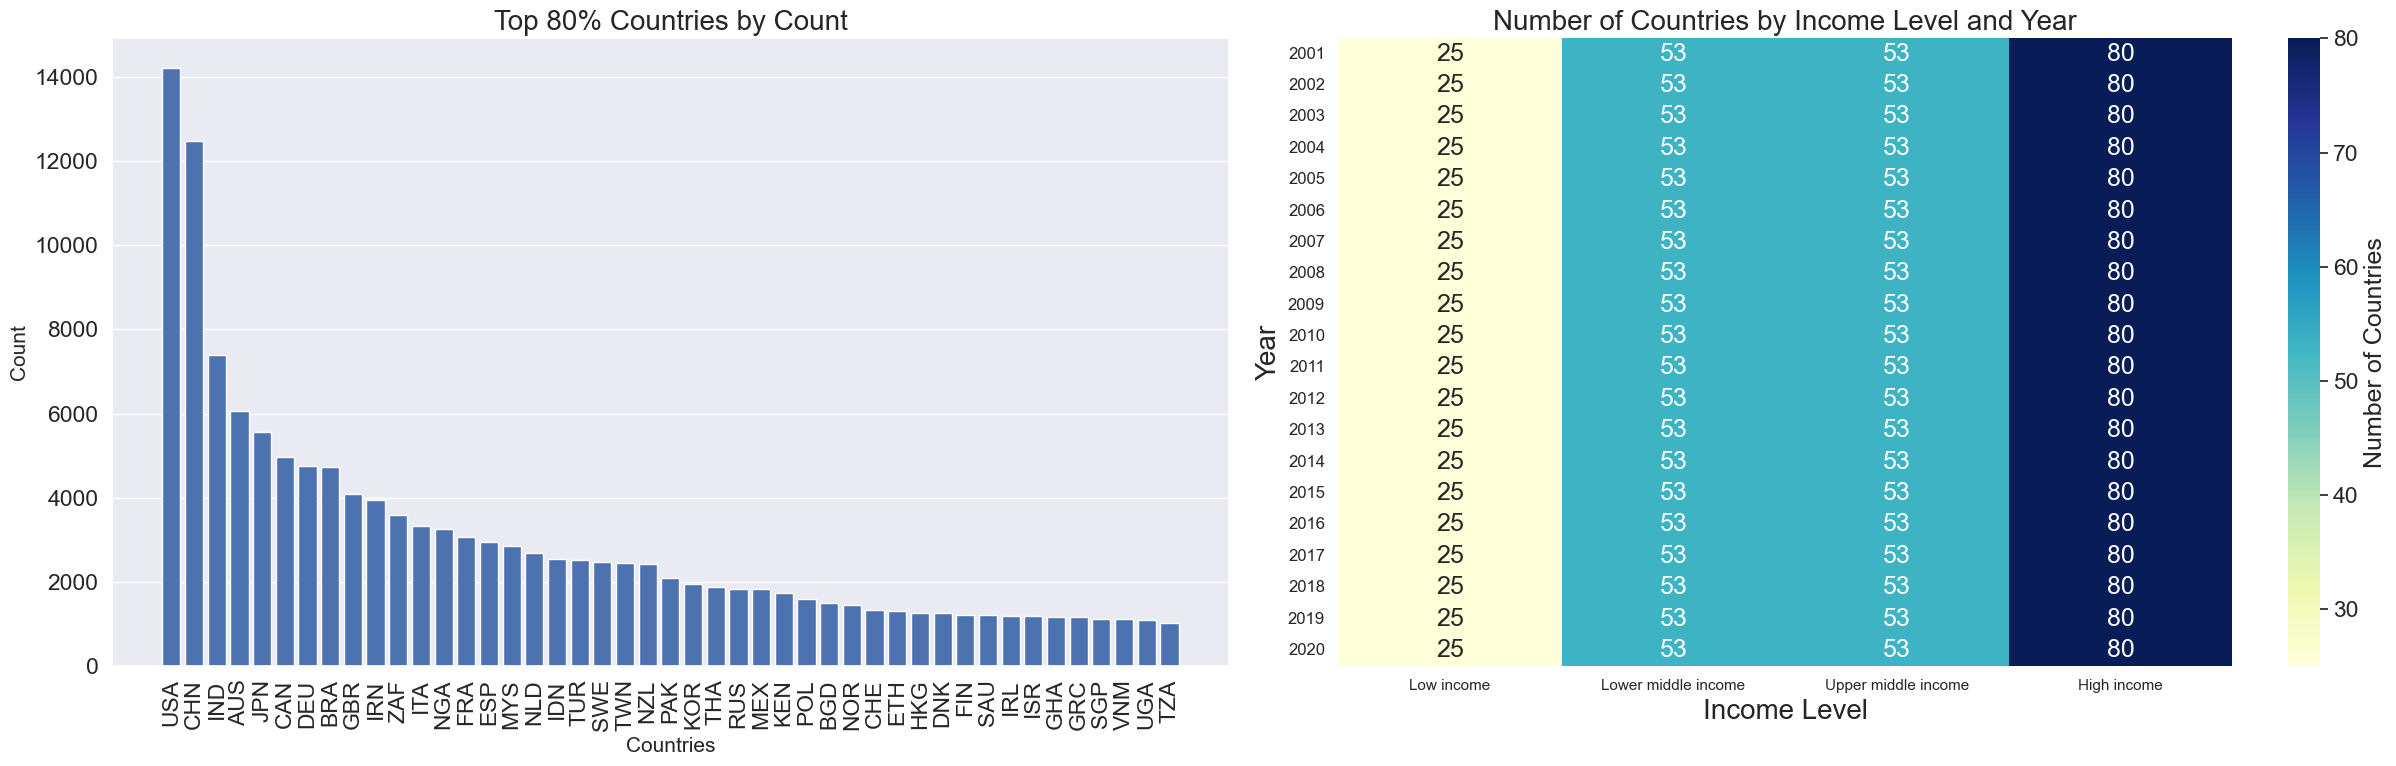

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8))
axs[0].bar(top_countries_names, top_countries_counts)
axs[0].set_title("Top 80% Countries by Count", fontsize=20)
axs[0].set_xlabel("Countries",fontsize=15)
axs[0].set_ylabel("Count",fontsize=15)
# axs[0].grid(axis='y')
axs[0].grid(axis='x')
axs[0].tick_params(axis='x', rotation=90)


sns.set(font_scale=1.5)
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt="g", cbar_kws={'label': 'Number of Countries'}, ax=axs[1])
axs[1].set_title("Number of Countries by Income Level and Year", fontsize=20)
axs[1].set_xlabel("Income Level", fontsize=20)
axs[1].set_ylabel("Year", fontsize=20)
axs[1].tick_params(axis='x', labelsize=11, rotation=0)
axs[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.savefig('./figures/explore.pdf')
plt.savefig('./figures/explore.png', dpi=300)
plt.savefig('./figures/explore.svg')
plt.show()

# Median & Average

In [8]:
country_counts = {}
papers_per_year_by_country = {}
meadian_by_country = {}
median_by_year = {}

def create_year_by(chunk):
    global papers_per_year_by_country
    chunk = chunk.dropna()
    for year, journal, countries in zip(chunk['year'], chunk['journal'], chunk['countries']):
        year = str(year)
        countries = ast.literal_eval(countries)
        if year not in papers_per_year_by_country:
            papers_per_year_by_country[year] = {}
        for country in countries:
            if country == 'nf':
                continue
            if country in papers_per_year_by_country[year]:
                papers_per_year_by_country[year][country] += 1
            else:
                papers_per_year_by_country[year][country] = 1


In [9]:
chunk_size = 10000
data = pd.read_csv('./results_completed.csv', usecols=['year', 'journal', 'countries'], chunksize=chunk_size)

In [10]:
for chunk in data:
    create_year_by(chunk)

In [12]:
def calculate_median(papers_per_year_by_country):
    median_by_year = {}
    for year, country_counts in papers_per_year_by_country.items():
        counts = list(country_counts.values())
        if counts:
            median_by_year[year] = np.median(counts)
    return median_by_year

def find_top_performers(papers_per_year_by_country):
    top_performers_by_year = {}
    for year, country_counts in papers_per_year_by_country.items():
        top_country = max(country_counts, key=country_counts.get)
        top_performers_by_year[year] = (top_country, country_counts[top_country])
    return top_performers_by_year

def compare_top_performers_with_median(top_performers_by_year, median_by_year):
    comparison_results = []
    for year in top_performers_by_year:
        top_country, top_count = top_performers_by_year[year]
        median = median_by_year.get(year, None)
        if median is not None:
            comparison_results.append({
                "Year": year,
                "Top Country": top_country,
                "Top Country Count": top_count,
                "Median": median,
                "Difference from Median": top_count - median,
                "Percentage Difference": ((top_count - median) / median) * 100
            })
    return comparison_results


In [13]:
median_by_year = calculate_median(papers_per_year_by_country)
top_performers_by_year = find_top_performers(papers_per_year_by_country)
comparison_results = compare_top_performers_with_median(top_performers_by_year, median_by_year)
df_comparison = pd.DataFrame(comparison_results).sort_values(['Year', 'Top Country Count'], ascending=[True, False])

|    |   Year | Top Country   |   Top Country Count |   Median |   Difference from Median |   Percentage Difference |
|---:|-------:|:--------------|--------------------:|---------:|-------------------------:|------------------------:|
| 11 |   2001 | USA           |                 229 |      4   |                    225   |                 5625    |
| 18 |   2002 | USA           |                 264 |      4   |                    260   |                 6500    |
| 15 |   2003 | USA           |                 282 |      4.5 |                    277.5 |                 6166.67 |
|  6 |   2004 | USA           |                 433 |      6.5 |                    426.5 |                 6561.54 |
| 12 |   2005 | USA           |                 431 |      5   |                    426   |                 8520    |
|  7 |   2006 | USA           |                 458 |      7   |                    451   |                 6442.86 |
|  2 |   2007 | USA           |                 510 |      7   |                    503   |                 7185.71 |
|  5 |   2008 | USA           |                 543 |      7   |                    536   |                 7657.14 |
|  3 |   2009 | USA           |                 612 |      8   |                    604   |                 7550    |
| 14 |   2010 | USA           |                 657 |      8   |                    649   |                 8112.5  |
|  8 |   2011 | USA           |                 701 |     11   |                    690   |                 6272.73 |
| 13 |   2012 | USA           |                 782 |     11   |                    771   |                 7009.09 |
| 17 |   2013 | USA           |                 790 |     14.5 |                    775.5 |                 5348.28 |
|  0 |   2014 | CHN           |                 897 |     16   |                    881   |                 5506.25 |
|  9 |   2015 | CHN           |                1083 |     16   |                   1067   |                 6668.75 |
|  4 |   2016 | CHN           |                1212 |     16   |                   1196   |                 7475    |
| 16 |   2017 | CHN           |                1346 |     15   |                   1331   |                 8873.33 |
|  1 |   2018 | CHN           |                1221 |     13   |                   1208   |                 9292.31 |
| 10 |   2019 | CHN           |                1168 |     12.5 |                   1155.5 |                 9244    |
| 19 |   2020 | CHN           |                 291 |      4   |                    287   |                 7175    |

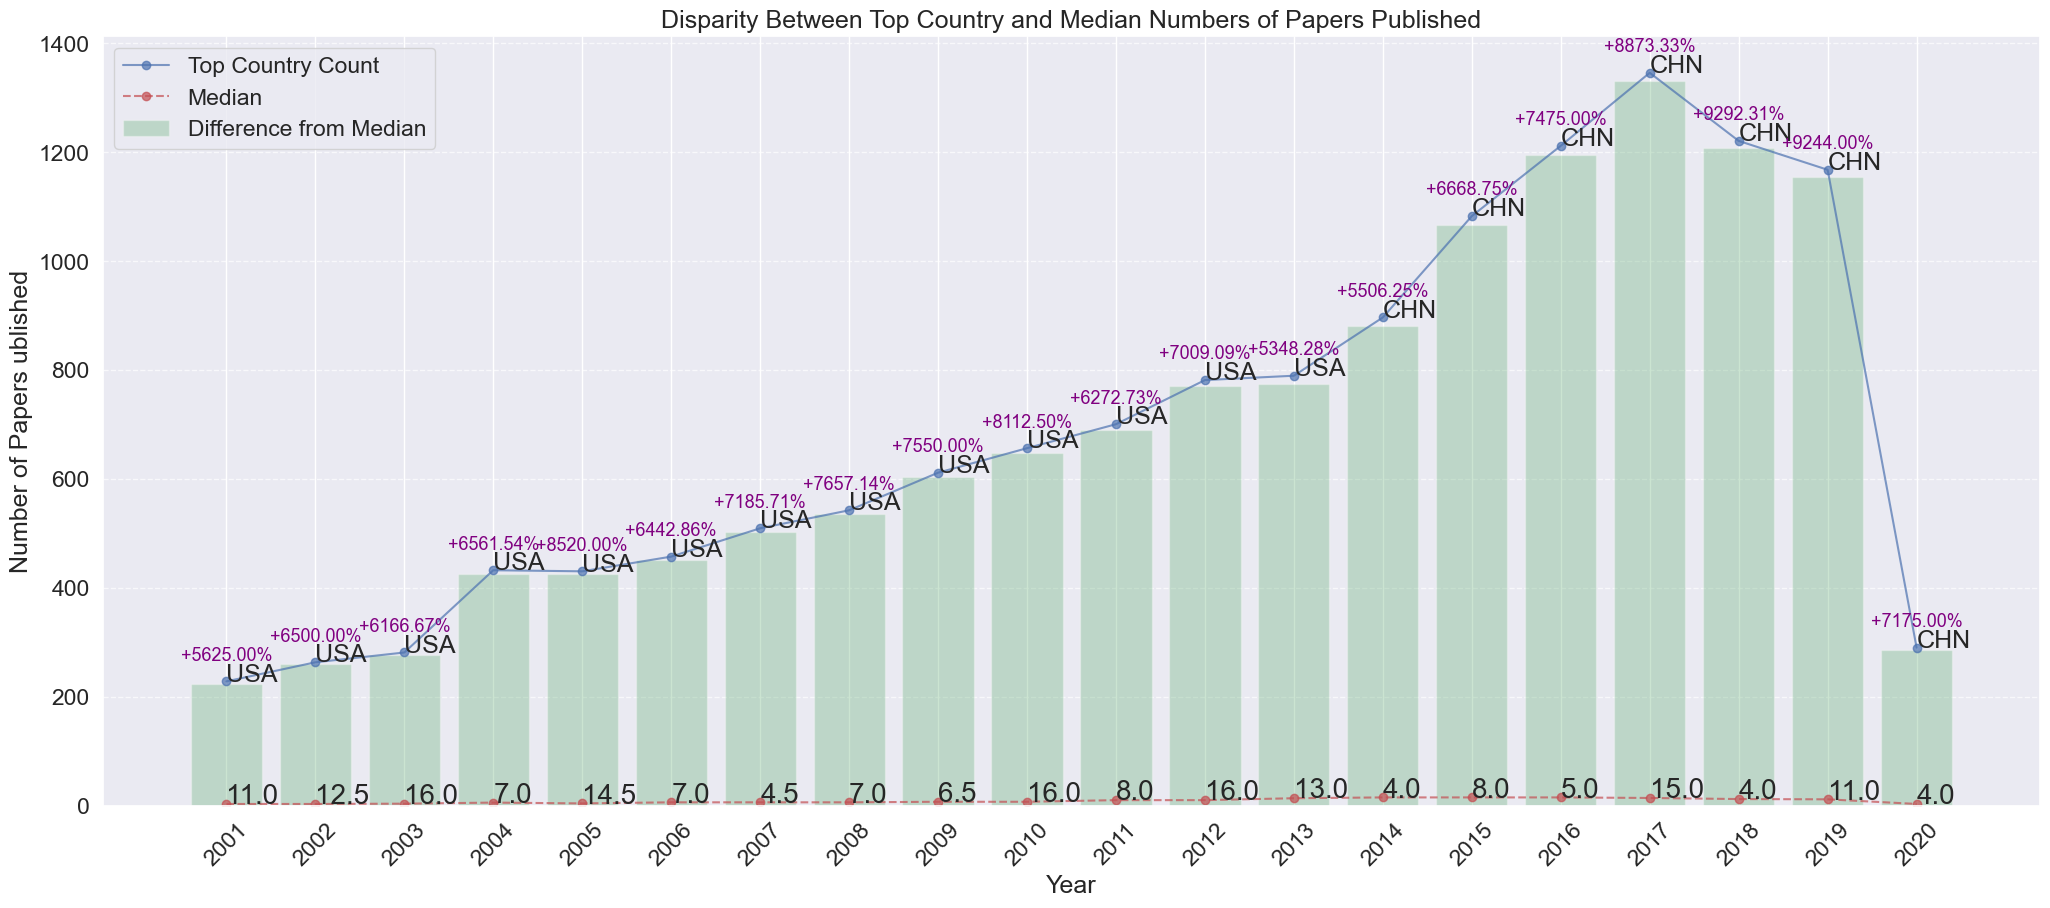

In [14]:
fig, ax = plt.subplots(figsize=(25, 10))
year = df_comparison['Year']
top_country_count = df_comparison['Top Country Count']
median = df_comparison['Median']

ax.plot(year, top_country_count, label='Top Country Count', marker='o', linestyle='-', color='b', alpha=0.7)
ax.plot(year, median, label='Median', marker='o', linestyle='--', color='r', alpha=0.7)

for i, label in enumerate(median):
    ax.annotate(label, (year[i],  median[i]), fontsize=20)
    ax.annotate(df_comparison['Top Country'][i], (year[i],  top_country_count[i]))
    pdiff = df_comparison['Percentage Difference'][i]
    ax.annotate(f'+{pdiff:.2f}%', (year[i], top_country_count[i]), textcoords="offset points", xytext=(0, 15), ha='center', color='purple', fontsize=13)

ax.bar(year, df_comparison['Difference from Median'], label='Difference from Median', color='g', alpha=0.3)

ax.set_title('Disparity Between Top Country and Median Numbers of Papers Published')
ax.set_ylabel('Number of Papers ublished')
ax.set_xlabel('Year')
ax.tick_params(axis='x', rotation=45,  which='major')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./figures/MeidanDisparity.pdf')
plt.savefig('./figures/MedianDisparity.png', dpi=300)
plt.savefig('./figures/MedianDisparity.svg')
plt.show()

# China's Research Boom and the COVID-19 Disruption

The dataset providees an interesting look at the global distribution of research output over a span of nearly two decades.

### China's Rise to Dominance (Post-2014)

- **From 2001 to 2013**, the United States consistently published more research papers than any other country, peaking at 790 papers in 2013. During this period, the difference in output between U.S. and other countries remained substantial, with the U.S. having the heighest counts year after year.

- **2014 - The Shift**: In 2014, China overtakes the U.S. for the first time, with 897 papers publised compared to the U.S. . This markks the beginning of a clear shift in global research dominance. The differeence between the U.S. and China continues to grow in the following years.

- **2015-2020: China's Contined Growth**: By 2015, China's output rises sharply to 1083 papers, overtaking the U.S. . The Gap widens further in 2016 (1,212 papers), 2017 (1,346 papers), and peaks in 2018 with 1,221 papers. The rapid growth in Chaina's research output highlights a clear thrend: China has increasingly become a global research leader, with signigicant investments in science and technology, a investments in science and technology, a growing research community, and a focus on higher education and innovation.

- **China's Reseach Growth**: China's percentage difference from the median (Percentage increase from the median) has consistently been high, especially post-2014. this indicates thath China has not only produceed more papers but has incresingly outpaced the global median, with a higher concentration of research output compared to other nations.

### **Imapct of COVID-19(2020)**

- **2020: A Drastic Decline**: The year 2020 standsd out as an anomaly. while the dataset shows China as still having the higheest count (291 papers), there is a dramatic drop in the total numbers of published papers from 2019 (1168 papers). This suggests a significant impact from the COVID-19 pandamic, which disrupted the global research ecosystem. Travel restrictions, lab clousers, and social distancing measures likely hindered researchers ability to conduct experiments, collaborate internationally, and publish their findings.

- **Percentage Drop**: The percentage difference from the mediann for China drops dramatically in 2020, reflecting a sharp deviation from the prior years' trends. This sharp decrease may be reflective of the broader global slowdown in academic and research activities, as institutions and researchers worldwide adjusted to realities of the pandemic.

- **Global Imapct**: The decline in research output in 2020 is not unique to China but is evident accross many countries. The world saw a shift in priorites as pandemic became the new norm. However, the magnitude of the decreasee in publishedd papers underscores the fragility of research prductivity in an unexpected global crises.

### **Other Interesting Insights**
- **Median Values**: The median numbers of papers published fluctuates across the yearrs, reflecting shifts in global research output. The median starts at alower value in earlier years but gradually increases as the overall research ouput grows globally.

# Sentivity

In [15]:
def process_paper_data(papers_per_year_by_country, median_by_year, runner_up_count=3):
    data = []
    for year, country_counts in papers_per_year_by_country.items():
        for country, count in country_counts.items():
            data.append({"Year": year, "Country": country, "Count": count})
    df_papers_per_year_by_country = pd.DataFrame(data).sort_values(['Year', 'Count'], ascending=[True, False])

    #Extract the top countries (runner_up_count) for each year
    years = sorted([data[0] for data in papers_per_year_by_country.items()])
    countries = set()
    for year in years:
        year_info = df_papers_per_year_by_country[df_papers_per_year_by_country['Year'] == str(year)][:runner_up_count]
        countries.update(year_info['Country'])

    #Calculate the percentage difference from the median for each country
    percentage_compare = []
    for year, country_counts in papers_per_year_by_country.items():
        for country, count in country_counts.items():
            median = median_by_year.get(year, None)
            if median is not None:
                percentage_compare.append({
                    "Year": year,
                    "Country": country,
                    "Country Count": count,
                    "Median": median,
                    "Difference from Median": count - median,
                    "Percentage Difference": ((count - median) / median) * 100
                })

    df_percentage_diff = pd.DataFrame(percentage_compare).sort_values(["Year", "Difference from Median"], ascending=[True, False])

    plot_data = {country: [] for country in countries}
    for year in years:
        year_info = df_papers_per_year_by_country[df_papers_per_year_by_country['Year'] == str(year)]
        year_countries = set(year_info['Country'])

        for country in countries:
            if country in year_countries:
                count = year_info[year_info['Country'] == country]['Count'].values[0]
            else:
                count = papers_per_year_by_country.get((year, country), 0)
            plot_data[country].append(count)
    return df_papers_per_year_by_country, df_percentage_diff, plot_data, years, countries

In [16]:
df_papers_per_year_by_country, df_percentage_diff, plot_data, years, countries = process_paper_data(papers_per_year_by_country, median_by_year)

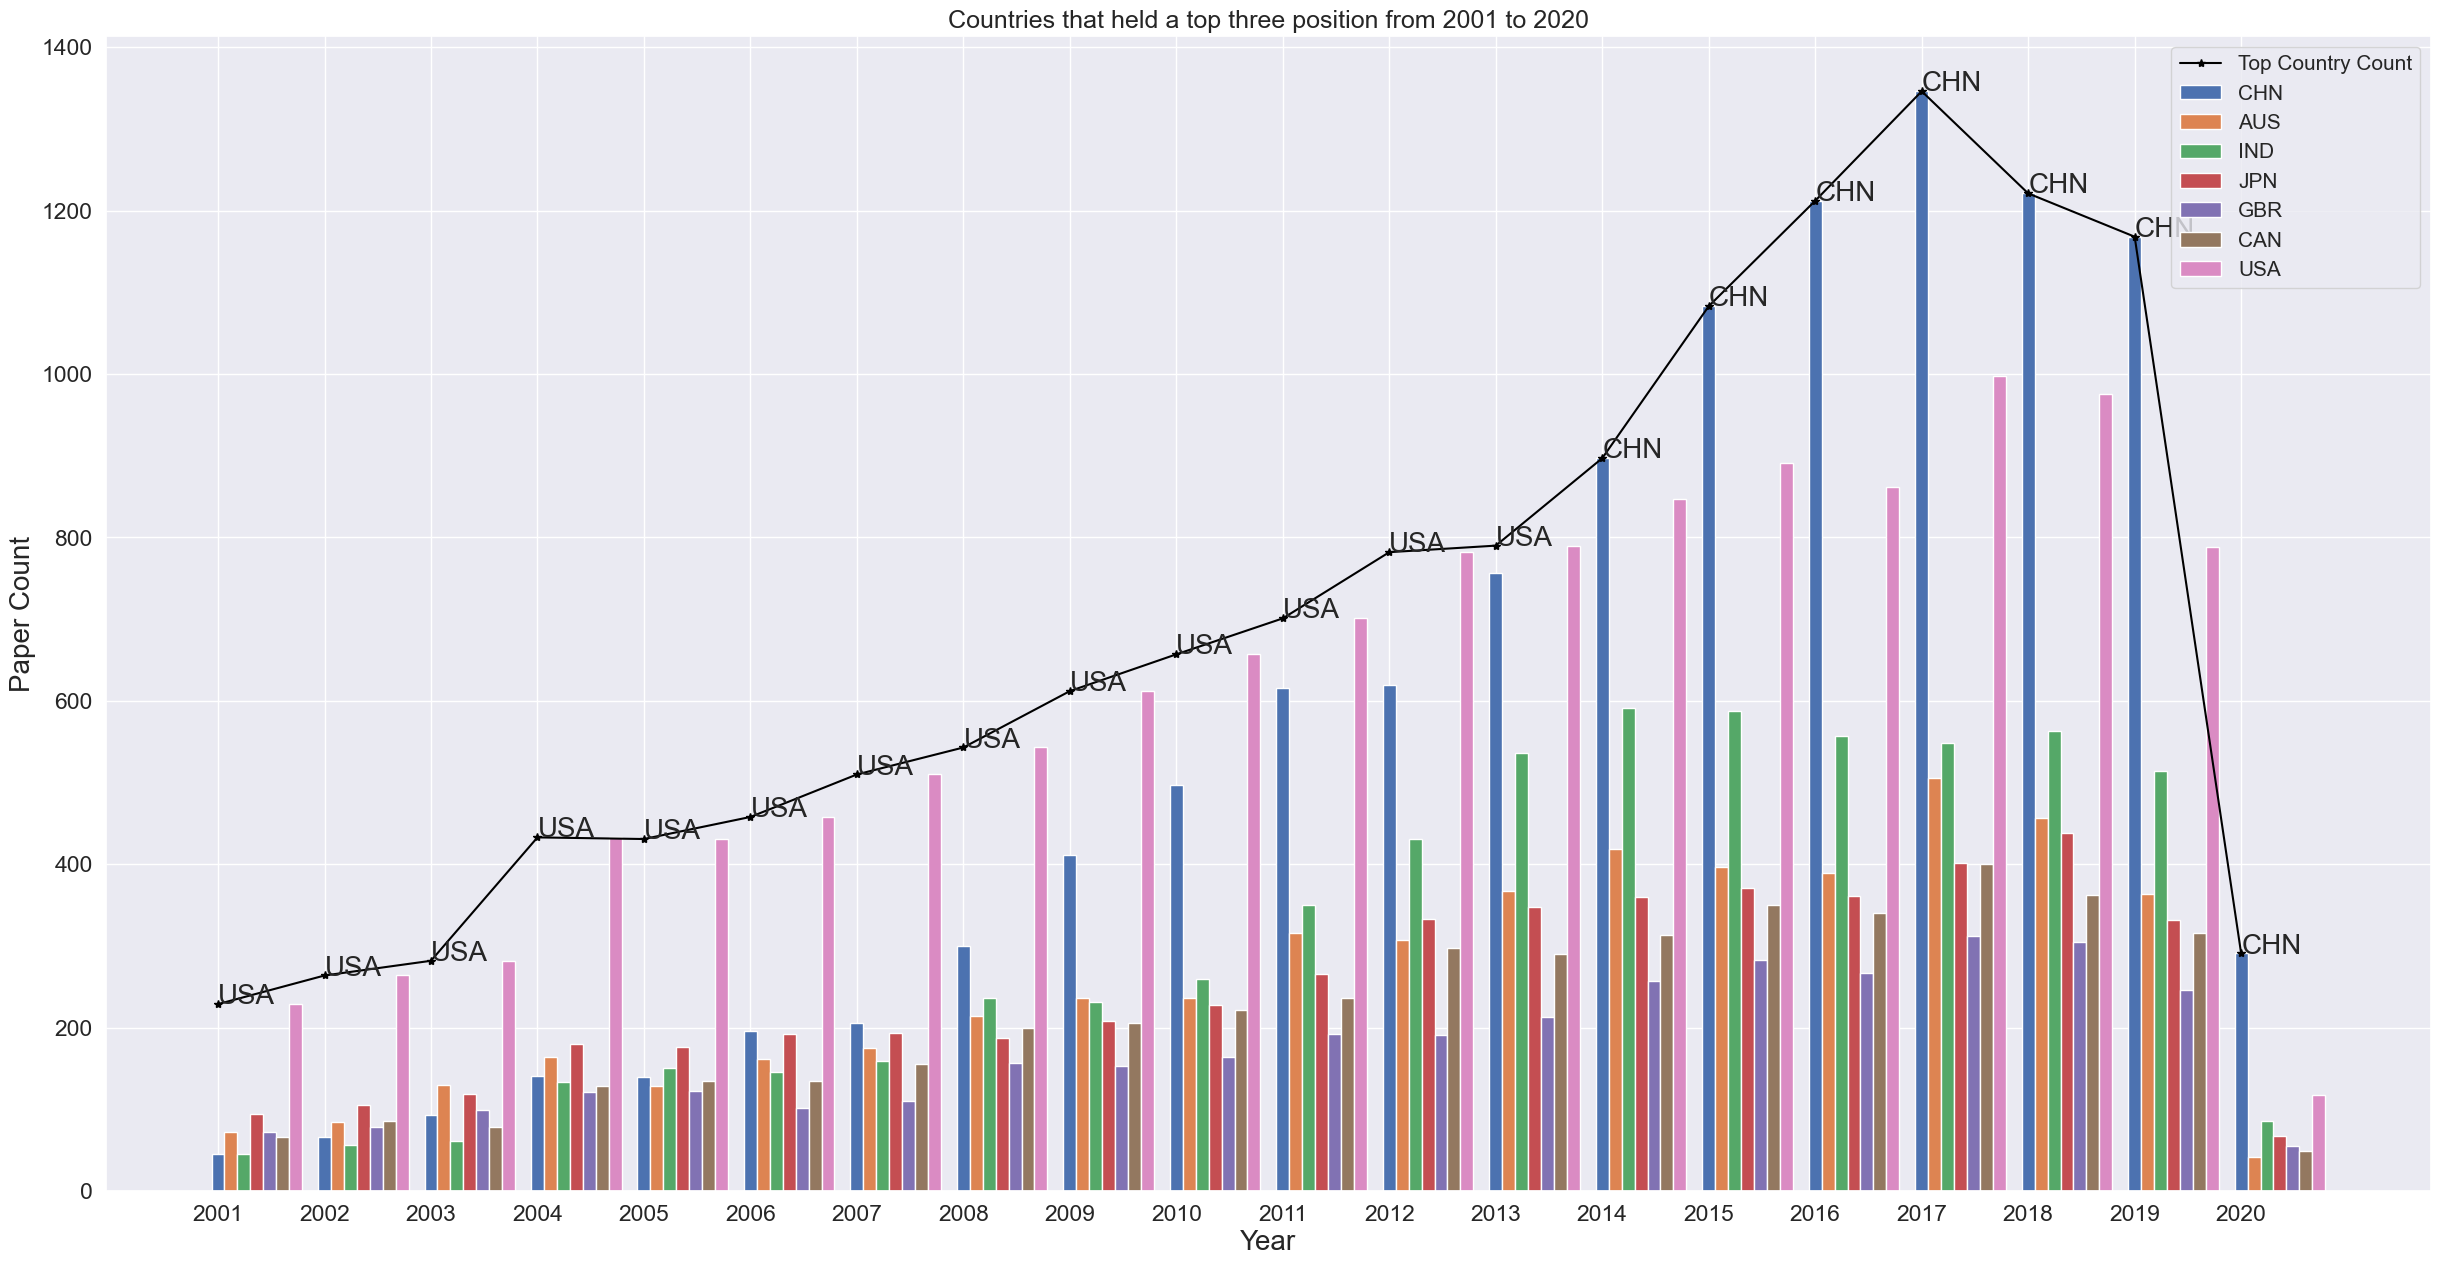

In [17]:

data = [plot_data[country] for country in countries]
x = np.arange(len(years))
# Width of the bars
width = 0.85 / len(countries)

fig, ax = plt.subplots(figsize=(30, 15))

for i, country in enumerate(countries):
    ax.bar(x + i * width, plot_data[country], width, label=country)

for i, label in enumerate(df_comparison['Median']):
    ax.annotate(
        df_comparison['Top Country'][i],
        (df_comparison['Year'][i], df_comparison['Top Country Count'][i]),
        fontsize=20
    )

ax.plot(df_comparison['Year'],df_comparison['Top Country Count'], label='Top Country Count', marker='*', color='black')
ax.set_title('Countries that held a top three position from 2001 to 2020', fontsize=18)
ax.set_xlabel('Year', fontsize=20)
ax.set_ylabel('Paper Count', fontsize=20)
ax.legend(fontsize=15)
plt.savefig('./figures/top3.pdf')
plt.savefig('./figures/top3.png', dpi=300)
plt.savefig('./figures/top3.svg')
plt.show()



In [18]:
def prepare_data_for_plotting(years, df_percentage_diff, df_papers_per_year_by_country, papers_per_year_by_country):
    percentage_country_bellow = set()
    for year in years:
        year_info = df_percentage_diff[df_percentage_diff['Year'] == year]
        year_info = year_info[year_info['Percentage Difference'] < 1000]
        year_info = year_info[year_info['Percentage Difference'] > 0]
        percentage_country_bellow.update(year_info['Country'])

    percentage_plot_data = {country: [] for country in percentage_country_bellow}

    for year in years:
        year_info = df_papers_per_year_by_country[df_papers_per_year_by_country['Year'] == year]
        year_countries = set(year_info['Country'])

        for country in percentage_country_bellow:
            if country in year_countries:
                count = year_info[year_info['Country'] == country]['Count'].values[0]
            else:
                count = papers_per_year_by_country.get((year, country), 0)
            percentage_plot_data[country].append(count)

    return percentage_plot_data, percentage_country_bellow


In [19]:
percentage_plot_data, percentage_country_bellow = prepare_data_for_plotting(years, df_percentage_diff, df_papers_per_year_by_country, papers_per_year_by_country)

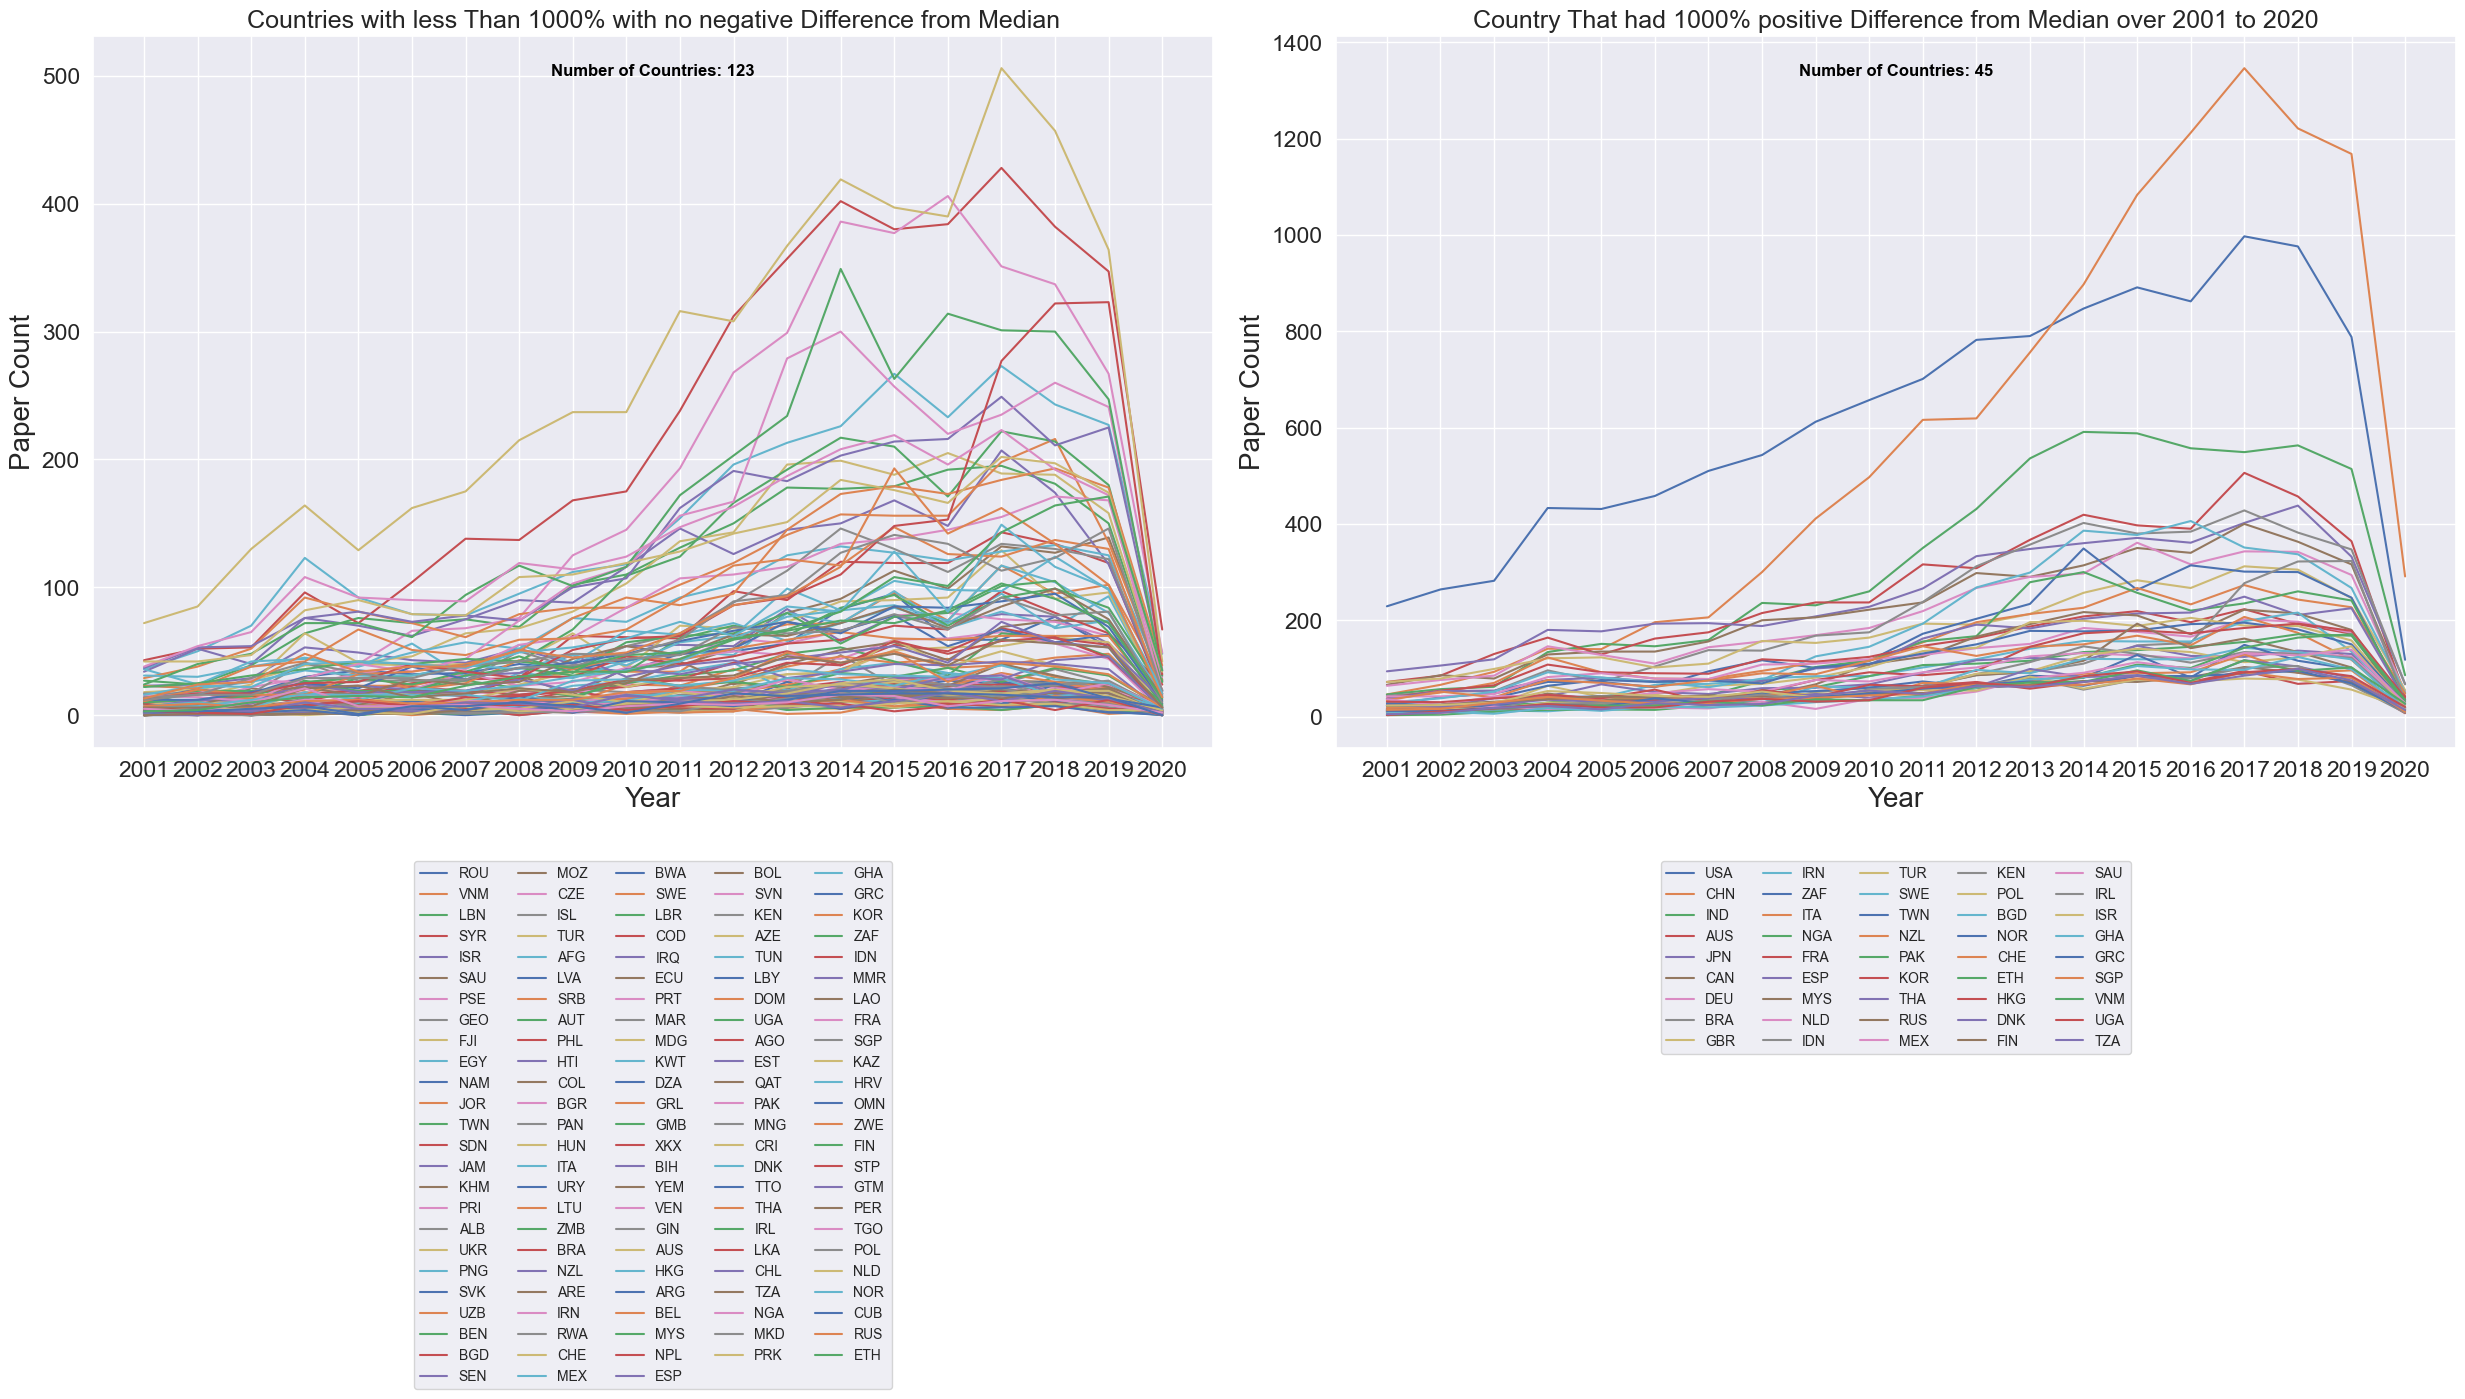

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(25, 15))

for country, counts in percentage_plot_data.items():
    axs[0].plot(years, counts, label=country)

num_countries = len(percentage_country_bellow)
axs[0].text(0.5, 0.95, f'Number of Countries: {num_countries}', ha='center', va='center', transform=axs[0].transAxes, fontsize=12, color='black', fontweight='bold')
axs[0].set_title('Countries with less Than 1000% with no negative Difference from Median', fontsize=18)
axs[0].set_xlabel('Year', fontsize=20)
axs[0].set_ylabel('Paper Count', fontsize=20)
axs[0].grid(True)
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=5)

top_countries_data = {country: [] for country in top_countries_names}

for year in years:
    year_info = df_papers_per_year_by_country[df_papers_per_year_by_country['Year'] == year]
    for country in top_countries_names:
        count = year_info[year_info['Country'] == country]['Count'].values[0] if country in year_info['Country'].values else 0
        top_countries_data[country].append(count)

for country, counts in top_countries_data.items():
    axs[1].plot(years, counts, label=country)

num_top_countries = len(top_countries_names)
axs[1].text(0.5, 0.95, f'Number of Countries: {num_top_countries}', ha='center', va='center', transform=axs[1].transAxes, fontsize=12, color='black', fontweight='bold')
axs[1].set_title('Country That had 1000% positive Difference from Median over 2001 to 2020', fontsize=18)
axs[1].set_xlabel('Year', fontsize=20)
axs[1].set_ylabel('Paper Count', fontsize=20)
axs[1].grid(True)

axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=5)

plt.tight_layout()
plt.savefig('./figures/Sentivity.pdf')
plt.savefig('./figures/Sentivity.png', dpi=300)
plt.savefig('./figures/Sentivity.svg')
plt.show()

In [21]:
def prepare_percentage_diff_data(df_percentage_diff, diff_from_median=1000):
    df_percentage_diff['Year'] = pd.to_numeric(df_percentage_diff['Year'], errors='coerce').astype(int)
    categories = {
        'Above 1000%': [],
        '0% to 1000%': [],
        'Below 0%': []
    }

    for year in df_percentage_diff['Year'].unique():
        year_info = df_percentage_diff[df_percentage_diff['Year'] == year]
        # print("Total : ",len(year_info))
        above_1000 = len(year_info[year_info['Percentage Difference'] > diff_from_median])
        zero_to_1000 = len(year_info[(year_info['Percentage Difference'] > 0) &
                                     (year_info['Percentage Difference'] <= diff_from_median)])
        below_0 = len(year_info[year_info['Percentage Difference'] < 0])
        # print("Total after split : ",above_1000+zero_to_1000+below_0)
        categories['Above 1000%'].append(above_1000)
        categories['0% to 1000%'].append(zero_to_1000)
        categories['Below 0%'].append(below_0)

    years = df_percentage_diff['Year'].unique()

    df_plot = pd.DataFrame(categories, index=years)
    return df_plot

In [22]:
df_plot = prepare_percentage_diff_data(df_percentage_diff)

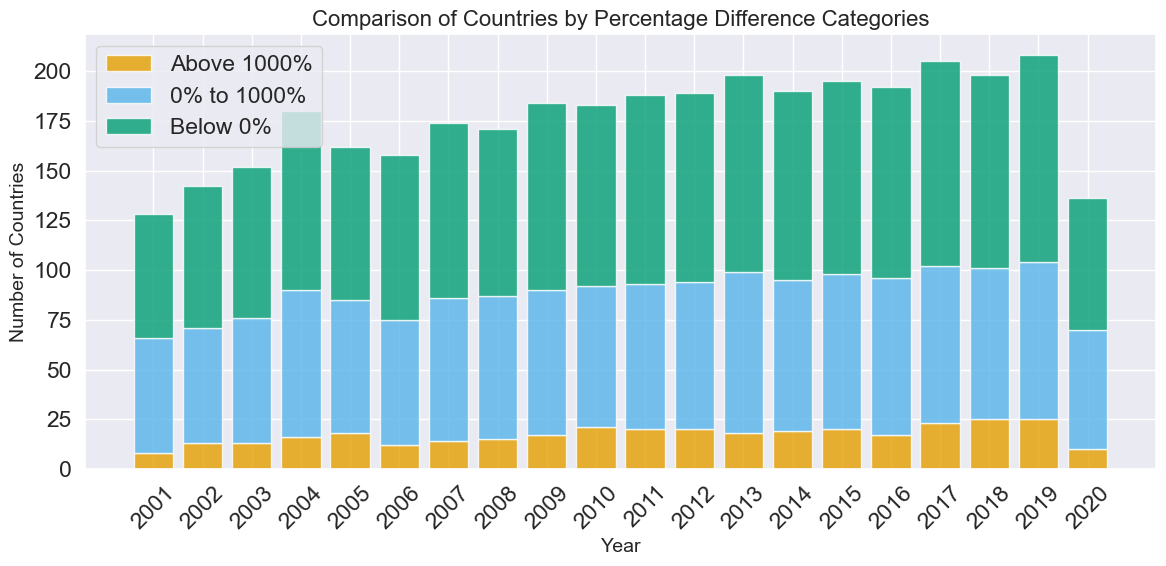

In [23]:
colors = ['#E69F00', '#56B4E9', '#009E73']

plt.figure(figsize=(12, 6))
plt.bar(df_plot.index, df_plot['Above 1000%'], label='Above 1000%', color=colors[0], alpha=0.8)
plt.bar(df_plot.index, df_plot['0% to 1000%'], bottom=df_plot['Above 1000%'], label='0% to 1000%', color=colors[1], alpha=0.8)
plt.bar(df_plot.index, df_plot['Below 0%'], bottom=df_plot['Above 1000%'] + df_plot['0% to 1000%'], label='Below 0%', color=colors[2], alpha=0.8)

plt.title('Comparison of Countries by Percentage Difference Categories', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Countries', fontsize=14)
plt.xticks(df_plot.index, [str(year) for year in df_plot.index], rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig('./figures/PercentageDiff.pdf')
plt.savefig('./figures/PercentageDiff.png', dpi=300)
plt.savefig('./figures/PercentageDiff.svg')
plt.show()

|      |   Above 1000% |   0% to 1000% |   Below 0% |
|-----:|--------------:|--------------:|-----------:|
| 2001 |             8 |            58 |         62 |
| 2002 |            13 |            58 |         71 |
| 2003 |            13 |            63 |         76 |
| 2004 |            16 |            74 |         90 |
| 2005 |            18 |            67 |         77 |
| 2006 |            12 |            63 |         83 |
| 2007 |            14 |            72 |         88 |
| 2008 |            15 |            72 |         84 |
| 2009 |            17 |            73 |         94 |
| 2010 |            21 |            71 |         91 |
| 2011 |            20 |            73 |         95 |
| 2012 |            20 |            74 |         95 |
| 2013 |            18 |            81 |         99 |
| 2014 |            19 |            76 |         95 |
| 2015 |            20 |            78 |         97 |
| 2016 |            17 |            79 |         96 |
| 2017 |            23 |            79 |        103 |
| 2018 |            25 |            76 |         97 |
| 2019 |            25 |            79 |        104 |
| 2020 |            10 |            60 |         66 |


#Income level and Research Output

In [24]:
def process_percentage_diff_and_categorize(papers_per_year_by_country, median_by_year, data_use, diff_from_median=1000):
    percentage_compare = []
    for year, country_counts in papers_per_year_by_country.items():
        for country, count in country_counts.items():
            median = median_by_year.get(year, None)
            if median is not None:
                percentage_compare.append({
                    "Year": year,
                    "Country": country,
                    "Country Count": count,
                    "Median": median,
                    "Difference from Median": count - median,
                    "Percentage Difference": ((count - median) / median) * 100
                })

    df_percentage_diff = pd.DataFrame(percentage_compare).sort_values(["Year", "Difference from Median"], ascending=[True, False])
    df_percentage_diff['Year'] = pd.to_numeric(df_percentage_diff['Year'], errors='coerce').astype(int)

    categories = {
        'Above 1000%': [],
        '0% to 1000%': [],
        'Below 0%': []
    }

    for year in df_percentage_diff['Year'].unique():
        year_info = df_percentage_diff[df_percentage_diff['Year'] == year]
        categories['Above 1000%'].extend(year_info[year_info['Percentage Difference'] > diff_from_median].to_dict(orient='records'))
        categories['0% to 1000%'].extend(year_info[(year_info['Percentage Difference'] > 0) & (year_info['Percentage Difference'] <= diff_from_median)].to_dict(orient='records'))
        categories['Below 0%'].extend(year_info[year_info['Percentage Difference'] < 0].to_dict(orient='records'))

    region_by_country = {row['iso3c']: row['region'] for _, row in data_use.iterrows()}
    income_level_by_country = {row['iso3c']: row['income_level'] for _, row in data_use.iterrows()}

    def prepare_data(category_data):
        aggregated_data = []
        for record in category_data:
            country = record['Country']
            count = record['Country Count']
            region = region_by_country.get(country, None)
            income_level = income_level_by_country.get(country, None)
            if region and income_level:
                aggregated_data.append([region, income_level, count])
        df = pd.DataFrame(aggregated_data, columns=['Region', 'Income Level', 'Count'])
        return df.groupby(['Income Level', 'Region'], as_index=False)['Count'].sum()

    df_above_1000 = prepare_data(categories['Above 1000%'])
    df_zero_to_1000 = prepare_data(categories['0% to 1000%'])
    df_below_0 = prepare_data(categories['Below 0%'])

    return df_above_1000, df_zero_to_1000, df_below_0

In [25]:
df_above_1000, df_zero_to_1000, df_below_0 = process_percentage_diff_and_categorize(papers_per_year_by_country, median_by_year, data_use)

In [26]:

def plot_bubble_chart(df, title, ylimit=None):
    income_order = ["Low income", "Lower middle income", "Upper middle income", "High income"]
    df['Income Level'] = pd.Categorical(df['Income Level'], categories=income_order, ordered=True)

    fig, ax = plt.subplots(figsize=(17, 12))
    scatter = ax.scatter(
        df['Income Level'].cat.codes,
        df['Count'],
        s=df['Count']/5,
        alpha=0.7,
        c=df['Count'],
        cmap='cividis',
        edgecolors="black",
        linewidth=0.5
    )

    for _, row in df.iterrows():
        ax.text(
            df['Income Level'].cat.codes.loc[row.name],
            row['Count'],
            f"{row['Region']} ({row['Count']})",
            fontsize=14, ha='center', va='bottom', color='black'
        )

    ax.set_xlabel('Income Level', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_title(title, fontsize=18)

    if ylimit:
        ax.set_ylim(0, ylimit)

    ax.set_xticks(np.arange(len(income_order)))
    ax.set_xticklabels(income_order, fontsize=15)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Count', fontsize=12)

    plt.tight_layout()
    plt.savefig(f'./figures/{title}.png', dpi=300)
    plt.savefig(f'./figures/{title}.svg')
    plt.savefig(f'./figures/{title}.pdf')
    plt.show()





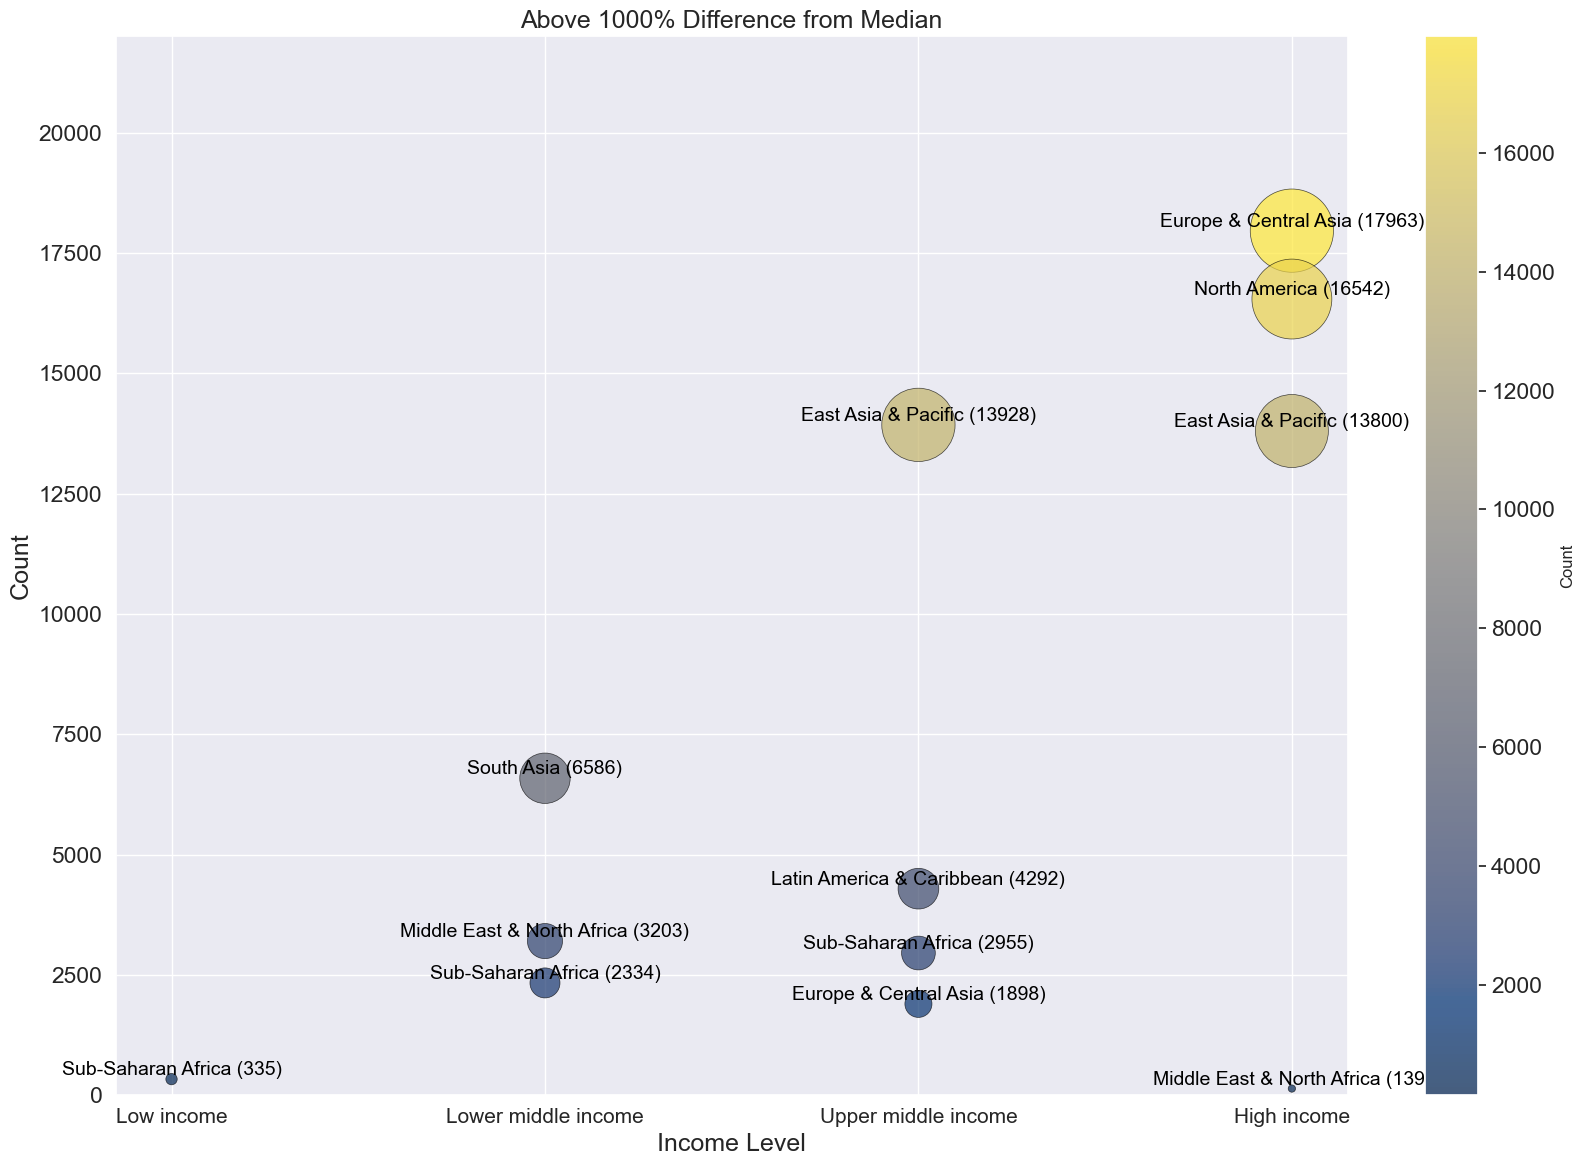

In [27]:
plot_bubble_chart(df_above_1000, "Above 1000% Difference from Median", ylimit=22000)


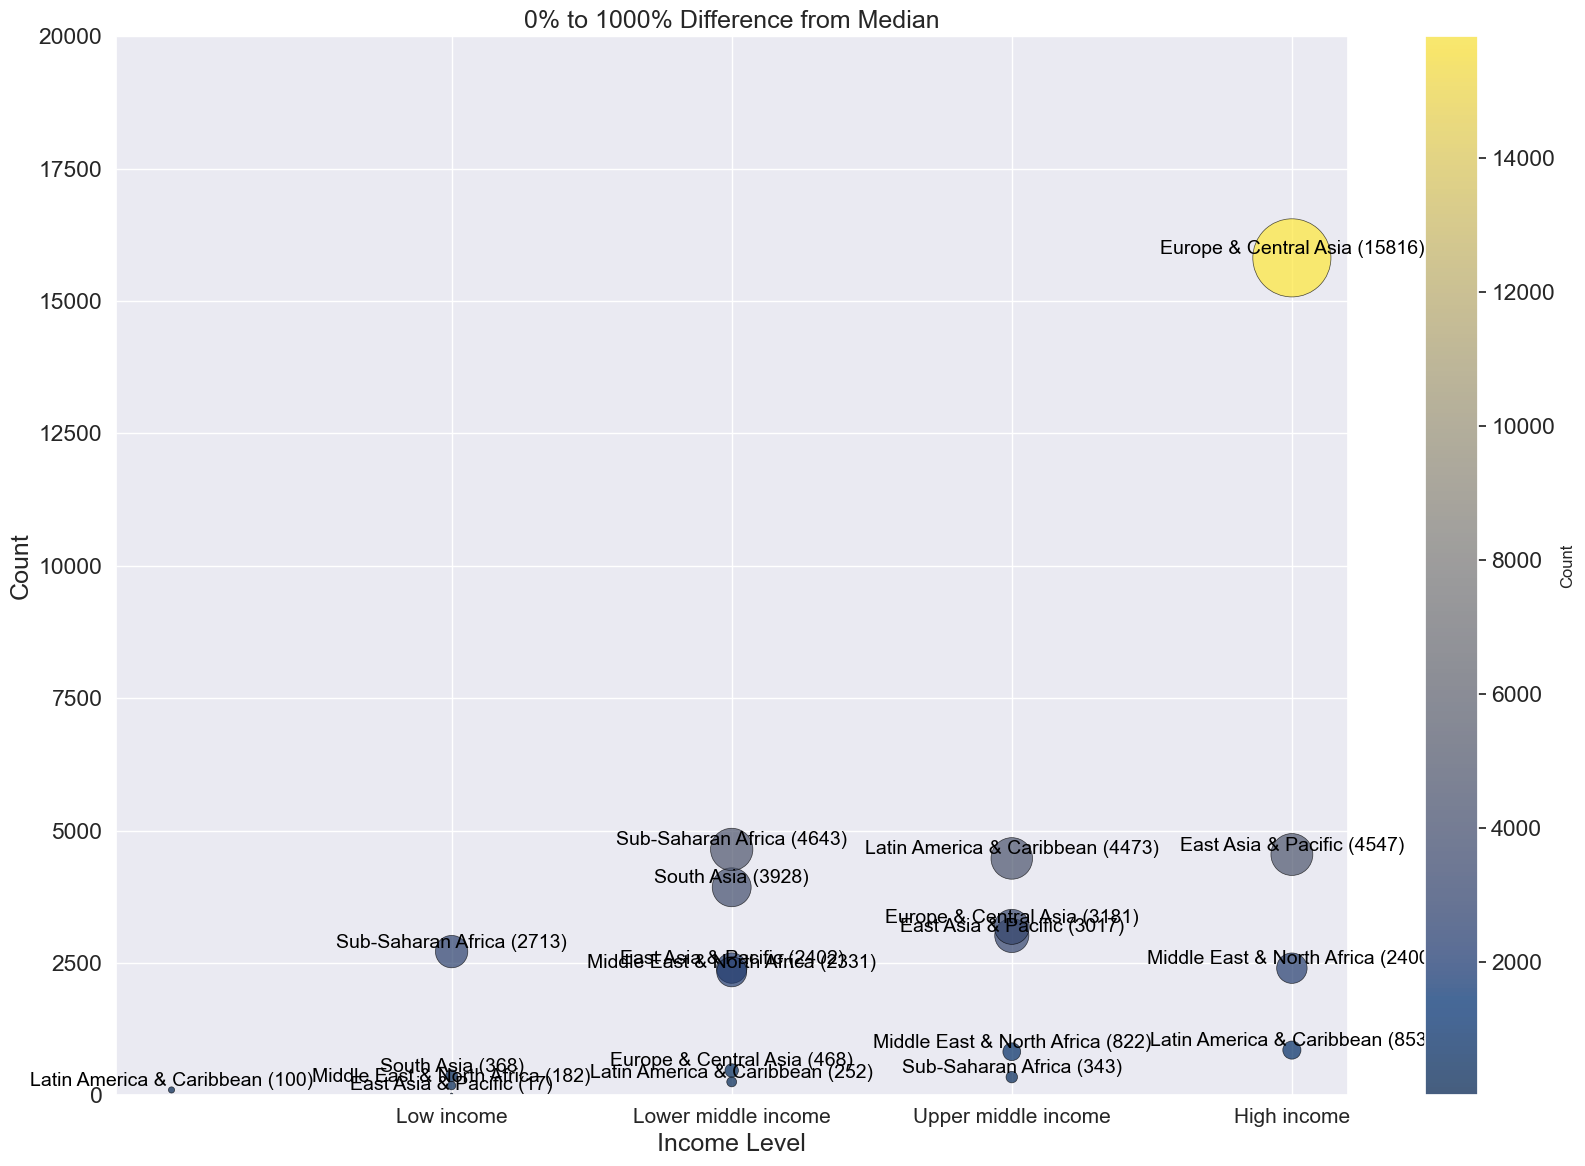

In [28]:

plot_bubble_chart(df_zero_to_1000, "0% to 1000% Difference from Median", ylimit=20000)

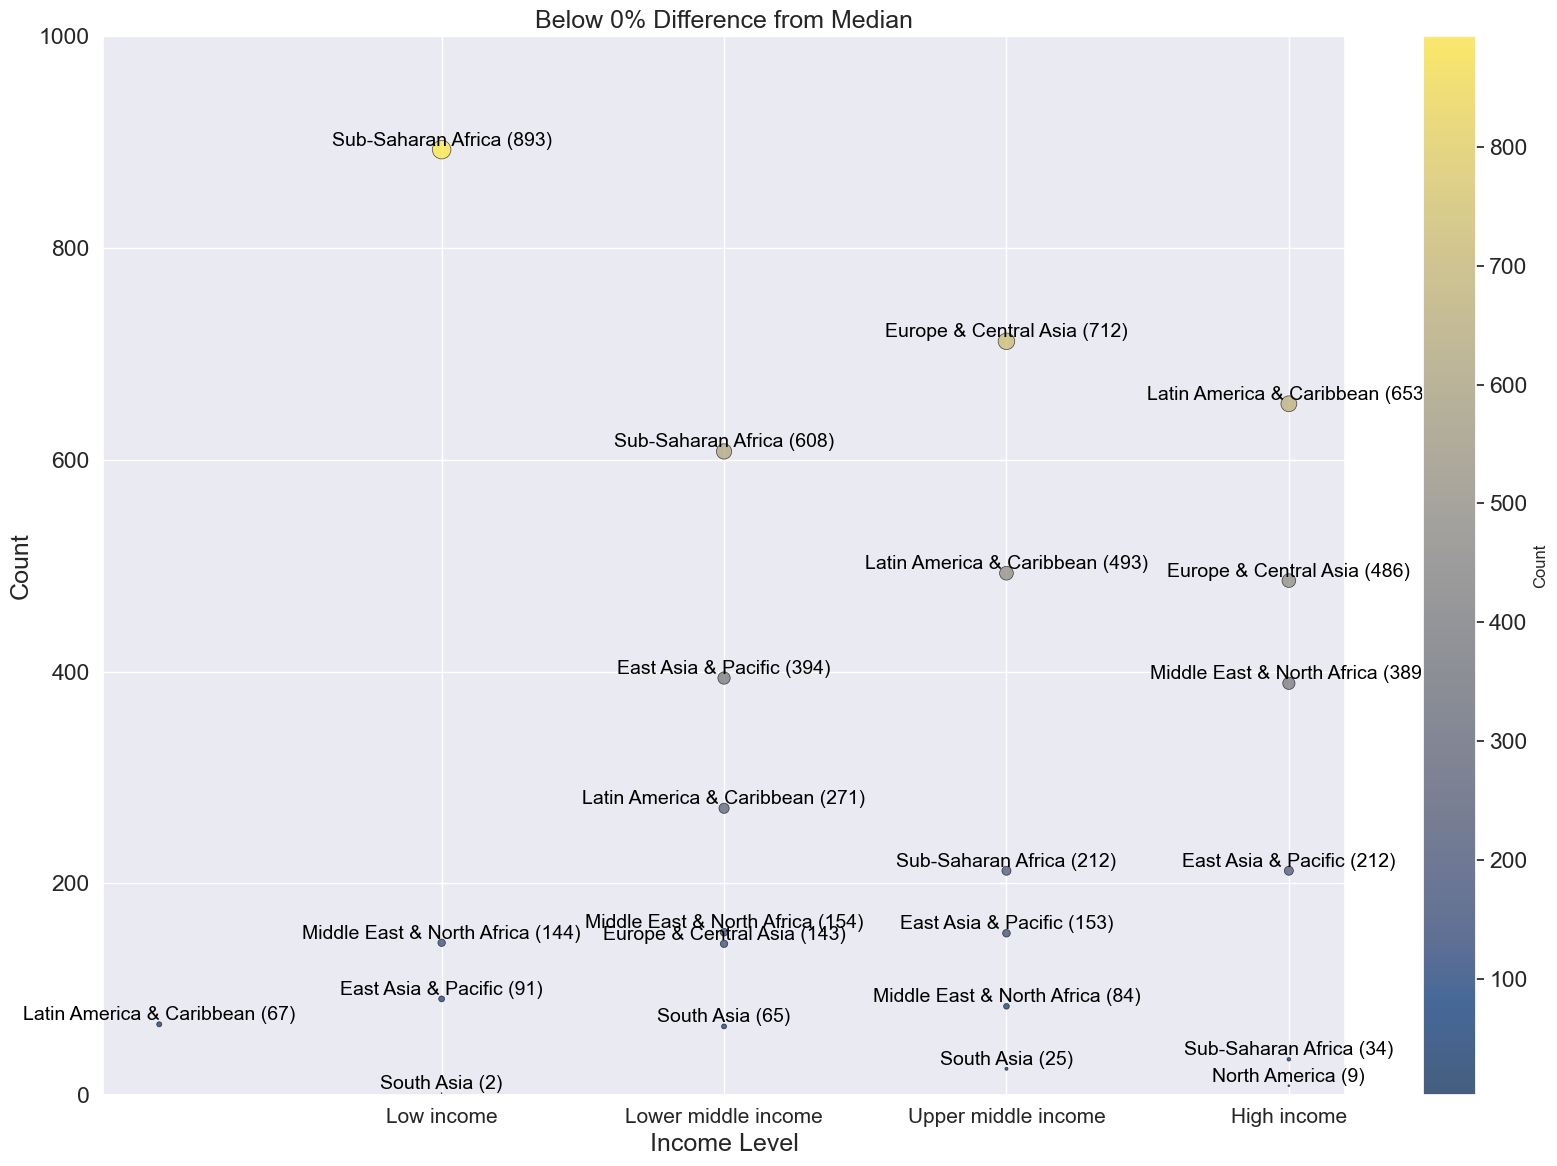

In [29]:
plot_bubble_chart(df_below_0, "Below 0% Difference from Median", ylimit=1000)


**Postive 1000 percent difference from Median**

|    | Income Level        | Region                     |   Count |
|---:|:--------------------|:---------------------------|--------:|
|  0 | High income         | East Asia & Pacific        |   13800 |
|  1 | High income         | Europe & Central Asia      |   17963 |
|  2 | High income         | Middle East & North Africa |     139 |
|  3 | High income         | North America              |   16542 |
|  4 | Low income          | Sub-Saharan Africa         |     335 |
|  5 | Lower middle income | Middle East & North Africa |    3203 |
|  6 | Lower middle income | South Asia                 |    6586 |
|  7 | Lower middle income | Sub-Saharan Africa         |    2334 |
|  8 | Upper middle income | East Asia & Pacific        |   13928 |
|  9 | Upper middle income | Europe & Central Asia      |    1898 |
| 10 | Upper middle income | Latin America & Caribbean  |    4292 |
| 11 | Upper middle income | Sub-Saharan Africa         |    2955 |

 **Greater than 0 and 1000 percent difference from Median**

|    | Income Level        | Region                     |   Count |
|---:|:--------------------|:---------------------------|--------:|
|  0 | High income         | East Asia & Pacific        |    4547 |
|  1 | High income         | Europe & Central Asia      |   15816 |
|  2 | High income         | Latin America & Caribbean  |     853 |
|  3 | High income         | Middle East & North Africa |    2400 |
|  4 | Low income          | East Asia & Pacific        |      17 |
|  5 | Low income          | Middle East & North Africa |     182 |
|  6 | Low income          | South Asia                 |     368 |
|  7 | Low income          | Sub-Saharan Africa         |    2713 |
|  8 | Lower middle income | East Asia & Pacific        |    2402 |
|  9 | Lower middle income | Europe & Central Asia      |     468 |
| 10 | Lower middle income | Latin America & Caribbean  |     252 |
| 11 | Lower middle income | Middle East & North Africa |    2331 |
| 12 | Lower middle income | South Asia                 |    3928 |
| 13 | Lower middle income | Sub-Saharan Africa         |    4643 |
| 14 | nan                 | Latin America & Caribbean  |     100 |
| 15 | Upper middle income | East Asia & Pacific        |    3017 |
| 16 | Upper middle income | Europe & Central Asia      |    3181 |
| 17 | Upper middle income | Latin America & Caribbean  |    4473 |
| 18 | Upper middle income | Middle East & North Africa |     822 |
| 19 | Upper middle income | Sub-Saharan Africa         |     343 |

**Below 0 percent difference from Median**

|    | Income Level        | Region                     |   Count |
|---:|:--------------------|:---------------------------|--------:|
|  0 | High income         | East Asia & Pacific        |     212 |
|  1 | High income         | Europe & Central Asia      |     486 |
|  2 | High income         | Latin America & Caribbean  |     653 |
|  3 | High income         | Middle East & North Africa |     389 |
|  4 | High income         | North America              |       9 |
|  5 | High income         | Sub-Saharan Africa         |      34 |
|  6 | Low income          | East Asia & Pacific        |      91 |
|  7 | Low income          | Middle East & North Africa |     144 |
|  8 | Low income          | South Asia                 |       2 |
|  9 | Low income          | Sub-Saharan Africa         |     893 |
| 10 | Lower middle income | East Asia & Pacific        |     394 |
| 11 | Lower middle income | Europe & Central Asia      |     143 |
| 12 | Lower middle income | Latin America & Caribbean  |     271 |
| 13 | Lower middle income | Middle East & North Africa |     154 |
| 14 | Lower middle income | South Asia                 |      65 |
| 15 | Lower middle income | Sub-Saharan Africa         |     608 |
| 16 | nan                 | Latin America & Caribbean  |      67 |
| 17 | Upper middle income | East Asia & Pacific        |     153 |
| 18 | Upper middle income | Europe & Central Asia      |     712 |
| 19 | Upper middle income | Latin America & Caribbean  |     493 |
| 20 | Upper middle income | Middle East & North Africa |      84 |
| 21 | Upper middle income | South Asia                 |      25 |
| 22 | Upper middle income | Sub-Saharan Africa         |     212 |

### **Overview of the Bubble Chart Distribution**  
The bubble chart provides a clear representation of research output across different income levels and regions. The x-axis orders income levels from low to high, while the y-axis captures the number of published papers. Bubble sizes correspond to the magnitude of publications, making it easy to compare regional research activity at each income level. The visualization highlights both expected patterns, such as the dominance of high-income regions, and unexpected trends, such as the variability within each income group.

### **Research Output in High-Income Regions**  
The "Positive 1000 Percent Difference from Median" chart prominently features high-income regions like Europe & Central Asia and North America with the largest bubbles, indicating their leading positions in global research output. Europe & Central Asia, in particular, stands out with an impressive 17,963 papers, positioned at the upper end of the y-axis. However, within high-income regions, there are surprising data points, such as the **Middle East & North Africa**, which shows a significantly smaller bubble with just 139 papers. This contrast illustrates that while wealth enables higher research productivity, other factors such as research funding, policies, and political stability play crucial roles.

### **Lower and Middle-Income Regions: Emerging Contributions**  
 South Asia, in particular, displays a sizable bubble, representing 3,928 papers, reflecting significant progress in academic output despite economic constraints. Similarly, Sub-Saharan Africa, with contributions from both low-income and lower-middle-income categories, demonstrates growth in research. These findings suggest that some regions are building robust academic frameworks.

### **Challenges in Low-Income Regions**
low-income South Asia shows the smallest bubble with just 2 papers, emphasizing the significant challenges faced by underdeveloped regions in contributing to global research. This is mirrored in other low-income regions, such as Sub-Saharan Africa, which produces relatively modest outputs. Even within high-income areas, there are outliers, such as North America’s unexpectedly small bubble of 9 papers in this category.

In [30]:
def calculate_skewness_and_median_stats(df_papers_per_year_by_country, df_comparison, papers_per_year_by_country, median_by_year, average_papers_by_country, years):
    greater_median_count = []
    below_median_count = []

    for i, year in enumerate(years):
        year_info = df_papers_per_year_by_country[df_papers_per_year_by_country['Year'] == str(year)]
        _total_count = len(year_info)
        year_info = year_info[year_info['Count'] >= df_comparison['Median'][i]]
        _greater_count = len(year_info)
        greater_median_count.append(_greater_count)
        below_median_count.append(_total_count - _greater_count)

    skewness_per_year_median = []
    skewness_per_year_average = []
    years = sorted(list(median_by_year.keys()))

    for year in years:
        year_data = papers_per_year_by_country.get(str(year), {})
        paper_counts_per_country = list(year_data.values())
        median_for_year = median_by_year[year]
        average_for_year = [average_papers_by_country.get(country, 0) for country in year_data.keys()]

        # Skew of number of papers per country
        skewness_per_year_median.append(skew(paper_counts_per_country))
        # Skew of average papers per country
        skewness_per_year_average.append(skew(average_for_year))
    std_devs = []
    for year in years:
        year_data = papers_per_year_by_country.get(str(year), {})
        paper_counts_per_country = list(year_data.values())
        std_devs.append(np.std(paper_counts_per_country))

    return greater_median_count, below_median_count, skewness_per_year_median, skewness_per_year_average, std_devs


In [31]:
def calculate_average_papers_per_country():
    global papers_per_year_by_country
    total_papers_by_country = {}
    total_years_by_country = {}

    for year, country_data in papers_per_year_by_country.items():
        for country, paper_count in country_data.items():
            if country not in total_papers_by_country:
                total_papers_by_country[country] = 0
                total_years_by_country[country] = 0
            total_papers_by_country[country] += paper_count
            total_years_by_country[country] += 1

    average_papers_by_country = {
        country: total_papers_by_country[country] / total_years_by_country[country]
        for country in total_papers_by_country
    }

    return average_papers_by_country

average_papers_by_country = calculate_average_papers_per_country()

In [32]:
greater_median_count, below_median_count, skewness_per_year_median, skewness_per_year_average, std_devs = calculate_skewness_and_median_stats(df_papers_per_year_by_country, df_comparison, papers_per_year_by_country, median_by_year, average_papers_by_country, years)


/var/folders/3c/vxqxzgl947b763q5x0kmq9h00000gn/T/ipykernel_48516/1806790833.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(years, rotation=45, fontsize=15)
/var/folders/3c/vxqxzgl947b763q5x0kmq9h00000gn/T/ipykernel_48516/1806790833.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(years, rotation=45, fontsize=15)


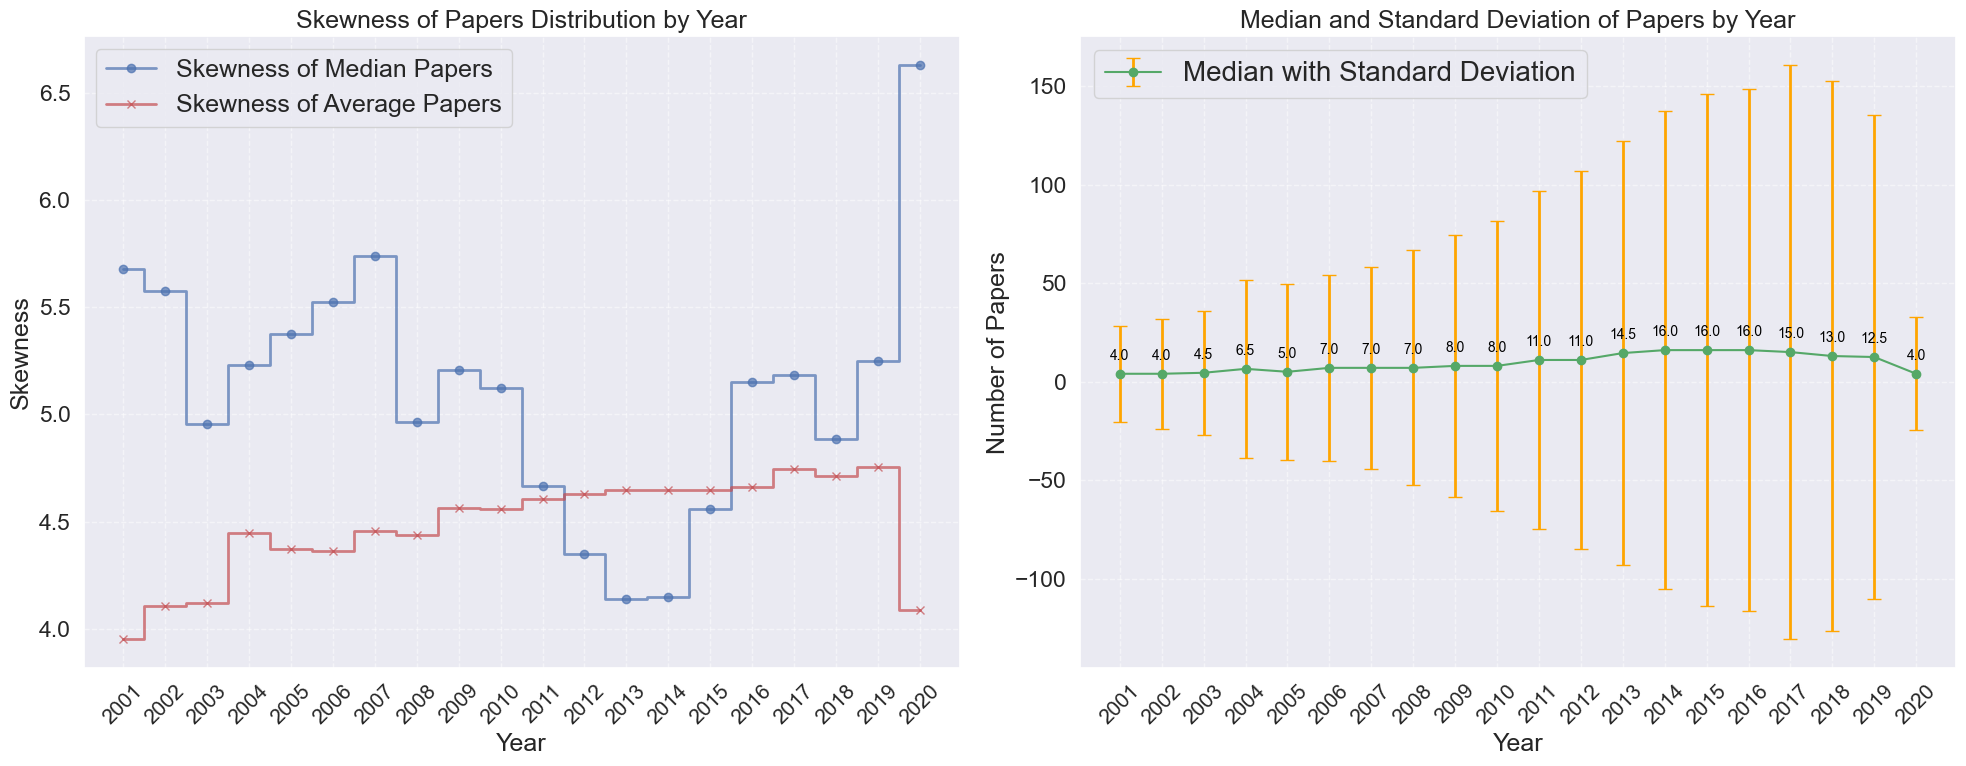

In [33]:
medians = df_comparison['Median']
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].step(years, skewness_per_year_median, label='Skewness of Median Papers', marker='o', where='mid', color='b', linewidth=2, alpha=0.7)
axs[0].step(years, skewness_per_year_average, label='Skewness of Average Papers', marker='x', where='mid', color='r', linewidth=2, alpha=0.7)
axs[0].set_title('Skewness of Papers Distribution by Year', fontsize=18)
axs[0].set_xlabel('Year', fontsize=18)
axs[0].set_ylabel('Skewness', fontsize=18)
axs[0].legend(fontsize=18)
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].set_xticklabels(years, rotation=45, fontsize=15)

axs[1].errorbar(
    years,
    medians,
    yerr=std_devs,
    fmt='-o',
    color='g',
    ecolor='orange',
    elinewidth=2,
    capsize=5,
    label='Median with Standard Deviation'
)
for year, median, std_dev in zip(years, medians, std_devs):
    axs[1].annotate(
        f'{median:.1f}',
        (year, median),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center',
        fontsize=10,
        color='black'
    )
axs[1].set_title('Median and Standard Deviation of Papers by Year', fontsize=18)
axs[1].set_xlabel('Year', fontsize=18)
axs[1].set_ylabel('Number of Papers', fontsize=18)
axs[1].legend(fontsize=20)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].set_xticklabels(years, rotation=45, fontsize=15)

plt.tight_layout()
plt.savefig('./figures/skewness_and_median.png', dpi=300)
plt.savefig('./figures/skewness_and_median.svg')
plt.savefig('./figures/skewness_and_median.pdf')
plt.show()

### **Median Skewness:**
The skewness for the **median** values of the number of papers published by each country varies from around **4.14** to **6.63** across the years. This indicates a **positive skewness**, meaning that the distribution of the number of papers published by countries is **right-skewed** in most years.

In simple terms, a **positive skew means that in most years, a small number of countries are publishing a disproportionately large number of papers** compared to the majority of countries. The larger the skewness value, the more pronounced this effect is, with a few countries contributing a significant proportion of total scientific publications.

#### **Key Observations:**
- **High Skewness in 2020 (6.63)**: The year 2020 exhibits the highest skewness, suggesting that a very small number of countries (perhaps due to the pandemic or other factors) contributed most of the research output. This might reflect global shifts in scientific focus or funding during that period.
- **Stable Skewness (around 5)**: Most years have skewness values clustered around **5**, indicating a similar distribution across multiple years. This pattern suggests that in general, the global scientific output has been concentrated in the hands of a few countries.

### **Average Skewness:**
The skewness for the **average** number of papers published by each country is somewhat lower, ranging from around **4.09** to **4.75**. While this is still a **positive skew**, it is less extreme compared to the skewness of the median. The skewness for the average papers published is consistently in the **4.x** range, which suggests a **more balanced distribution** but still highlights the presence of outliers in some years.

#### **Key Observations:**
- **Consistent but Lower Skewness**: The **average skewness** values are generally lower than the **median skewness**, reflecting that the calculation of the **average dampens the influence of extreme outliers**. The average can be affected by very high values, but not as much as the median, which is more resistant to extreme values.
- **Gradual Decrease in Skewness**: There is a slight decrease in skewness from **4.75** (2020) to **3.95** (2001), indicating that the **concentration of scientific output among a few countries** might have been slightly more pronounced in the later years. **The skewness decrease towards earlier years suggests a somewhat more even distribution in scientific publications.**


### **Comparing Median and Average Skewness:**
- The **median skewness** is consistently higher than the **average skewness** across almost all years. This is expected because the median, being a measure of central tendency, is more robust to extreme outliers, whereas the average can be heavily influenced by a small number of countries publishing a large number of papers.
- The larger values of skewness in the **median** data show that, even when outliers are accounted for, the global scientific community is characterized by a few dominant countries, particularly in recent years.

### **Interpretation:**
**Impact of Outliers**: The skewness of the **median** being higher than that of the **average** suggests that extreme outliers (countries with very high paper counts) have a stronger impact on the distribution when considering the median. This could indicate that a few countries dominate scientific publications in each year.

**Global Trends**: The increase in skewness values over time, particularly in the last few years (with 2020 being the highest), indicates a growing gap between countries in terms of research productivity.
##**Error Bars**:

   - The error bars (in orange) represent the standard deviation, which shows how spread out the number of papers is across countries.
   - A higher standard deviation means more variation in the number of papers published across countries for that year.
   - The standard deviation starts relatively low (\~24), increases significantly (\~130), and fluctuates in the later years, reflecting growing disparities among countries.

   - The median generally increases over time, which might suggest a global upward trend in paper production.
   - The standard deviation also grows, indicating that while some countries are contributing more papers, disparities between countries are also becoming more pronounced.

